In [1]:

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az
import pytensor.tensor as tt

rng = np.random.default_rng(1331)

In [2]:
pxi_df = pd.read_csv(r"data/pxi_results.csv")

pxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   participant_id  127 non-null    object 
 1   game_name       127 non-null    object 
 2   trial           127 non-null    float64
 3   mode            127 non-null    float64
 4   difficulty      127 non-null    float64
 5   pxi_AA          126 non-null    object 
 6   pxi_CH          127 non-null    object 
 7   pxi_EC          127 non-null    object 
 8   pxi_GR          127 non-null    object 
 9   pxi_PF          127 non-null    object 
 10  pxi_AUT         126 non-null    object 
 11  pxi_CUR         127 non-null    object 
 12  pxi_IMM         126 non-null    object 
 13  pxi_MAS         126 non-null    object 
 14  pxi_MEA         127 non-null    object 
 15  pxi_ENJ         127 non-null    object 
 16  STIMES          127 non-null    float64
 17  TIMES           127 non-null    flo

In [3]:
logs_df = pd.read_csv(r"data/atari_logs.csv").drop("Unnamed: 0", axis=1)

logs_df.head()

participant_id      game_name  trial  mode  difficulty  frame action  ram_0  \
0           P004  WordZapper-v5      1     2           3      0      0    182   
1           P004  WordZapper-v5      1     2           3      1      0    182   
2           P004  WordZapper-v5      1     2           3      2      0    182   
3           P004  WordZapper-v5      1     2           3      3      0    182   
4           P004  WordZapper-v5      1     2           3      4      0    182   

   ram_1  ram_2  ...  ram_118  ram_119  ram_120  ram_121  ram_122  ram_123  \
0    253    113  ...        0        0        0        0        0        0   
1    253    113  ...        0        0        0        0        0        0   
2    253    113  ...        0        0        0        0        0        0   
3    253    113  ...        0        0        0        0        0        0   
4    253    113  ...        0        0        0        0        0        0   

   ram_124  ram_125  ram_126  ram_127  
0      163       25      190      245  
1      163       25      190      245  
2      163       25      190      245  
3      163       25      190      245  
4      163       25      190      245  

[5 rows x 135 columns]

# Boxing

In [4]:
pxi_df_box = pxi_df[pxi_df["game_name"] == "Boxing"].drop(columns="game_name")

final_frames = logs_df[logs_df["game_name"]=="Boxing-v5"].groupby(["participant_id", "trial"])["frame"].idxmax()
grouped_box_df = logs_df.iloc[list(final_frames.values)]

box_score = grouped_box_df[["participant_id", "trial", "ram_18", "ram_19"]]
box_final = pd.merge(pxi_df_box, box_score, left_on=("participant_id", "trial"), right_on=("participant_id", "trial")).dropna()
box_final.head()


participant_id  trial  mode  difficulty          pxi_AA          pxi_CH  \
0           P009    3.0   0.0         0.0           Agree  Strongly Agree   
2           P015    3.0   0.0         0.0         Neutral           Agree   
3           P011    3.0   0.0         3.0           Agree           Agree   
4           P003    2.0   0.0         0.0  Strongly Agree  Slightly agree   
5           P013    1.0   0.0         2.0         Neutral           Agree   

           pxi_EC          pxi_GR          pxi_PF            pxi_AUT  \
0           Agree  Strongly Agree  Strongly Agree     Strongly Agree   
2           Agree  Strongly Agree  Slightly agree  slightly disagree   
3  Strongly Agree  Strongly Agree  Strongly Agree     Slightly agree   
4  Strongly Agree  Strongly Agree  Strongly Agree              Agree   
5           Agree  Strongly Agree  Strongly Agree            Neutral   

          pxi_CUR         pxi_IMM            pxi_MAS            pxi_MEA  \
0  Strongly Agree  Strongly Agree     Strongly Agree     Strongly Agree   
2         Neutral  Strongly Agree  slightly disagree  slightly disagree   
3           Agree  Strongly Agree              Agree     Strongly Agree   
4           Agree  Strongly Agree              Agree              Agree   
5         Neutral           Agree            Neutral  slightly disagree   

          pxi_ENJ        STIMES         TIMES  ram_18  ram_19  
0  Strongly Agree  1.746089e+12  1.746090e+12     119      72  
2         Neutral  1.746528e+12  1.746528e+12      32      56  
3  Strongly Agree  1.746111e+12  1.746111e+12      89      40  
4  Strongly Agree  1.745572e+12  1.745572e+12      36      49  
5  Slightly agree  1.746434e+12  1.746434e+12      18      18

In [5]:
box_final.shape

(40, 19)

In [6]:
pxi_id_to_number = {
    "strongly disagree": 0,
    "disagree": 1,
    "slightly disagree":2,
    "neutral": 3,
    "slightly agree": 4,
    "agree": 5,
    "strongly agree": 6
}

diff_order = {
    2:0,
    3:1,
    0:2,
    1:3
}

diff_id,   diff_cats = pd.factorize(box_final["difficulty"].replace(diff_order), sort=True)
ch_codes, ch_levels   = pd.factorize(box_final["pxi_CH"].str.lower().replace(pxi_id_to_number), sort=True)
mas_codes, mas_levels   = pd.factorize(box_final["pxi_MAS"].str.lower().replace(pxi_id_to_number), sort=True)
imm_codes, imm_levels   = pd.factorize(box_final["pxi_IMM"].str.lower().replace(pxi_id_to_number), sort=True)
scores                = box_final["ram_18"].values

/tmp/ipykernel_74662/3043601677.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ch_codes, ch_levels   = pd.factorize(box_final["pxi_CH"].str.lower().replace(pxi_id_to_number), sort=True)
/tmp/ipykernel_74662/3043601677.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mas_codes, mas_levels   = pd.factorize(box_final["pxi_MAS"].str.lower().replace(pxi_id_to_number), sort=True)
/tmp/ipykernel_74662/3043601677.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To ret

## H1: A game's difficulty configuration has an effect on a player's perception of immersion

In [7]:
with pm.Model(coords={"difficulties": diff_cats}) as m_boxh1:
    D = pm.Data("difficulty", diff_id)
    alpha = pm.Normal("alpha", 0,5)
    delta = pm.Dirichlet("delta", np.ones(len(diff_cats)-1)*5)
    pad = pm.math.concatenate([[0.0], delta])
    cum_delta = pm.Deterministic("cum_delta", pad.cumsum(), dims="difficulties")
    sigma = pm.Exponential("sigma", 1)
    
    eta = pm.Deterministic("eta", alpha*cum_delta[D])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,2,2), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=imm_codes)
    
    
    boxh1_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True},random_seed=rng, nuts_sampler="numpyro")
    

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,2]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

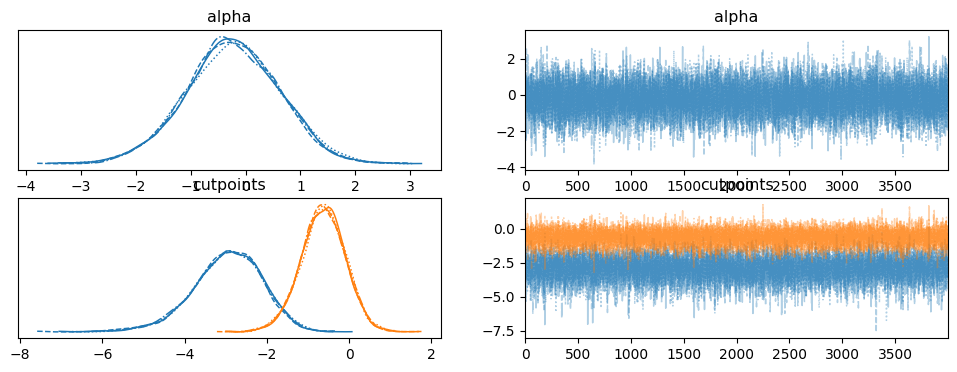

In [8]:
az.plot_trace(boxh1_trace, var_names=["alpha", "cutpoints"])

In [9]:
alpha_summary = az.summary(boxh1_trace, var_names=["alpha"])
alpha_summary

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha -0.237  0.86  -1.857    1.371      0.008    0.007   11782.0   10668.0   

       r_hat  
alpha    1.0

## H2. A game's difficulty configuration has an effect on a player's perception of Mastery



In [11]:
with pm.Model(coords={"difficulties": diff_cats}) as mboxh2:
    D = pm.Data("difficulty", diff_id)

    alpha = pm.Normal("alpha", 0,5)
    delta = pm.Dirichlet("delta", np.ones(len(diff_cats)-1)*5)
    pad = pm.math.concatenate([[0.0], delta])
    cum_delta = pm.Deterministic("cum_delta", pad.cumsum(), dims="difficulties")
    sigma = pm.Exponential("sigma", 1)
    
    eta = pm.Deterministic("eta", alpha*cum_delta[D])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=imm_codes)
    boxh2_trace = pm.sample_prior_predictive(draws=50, random_seed=rng)
    # boxh2_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng, nuts_sampler="numpyro")
    

Sampling: [alpha, cutpoints, delta, sigma, y]


<Axes: xlabel='y'>

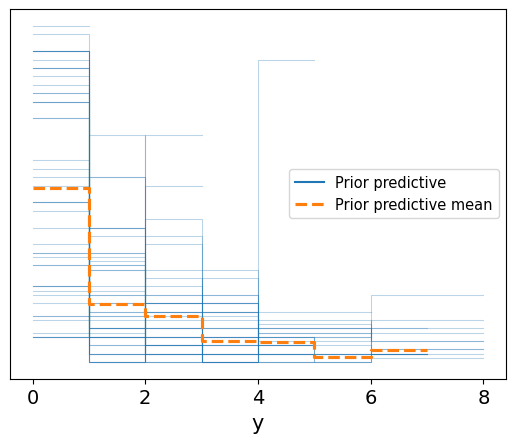

In [12]:
az.plot_ppc(
    boxh2_trace,
    data_pairs={"S": "S"},
    kind="kde",
    alpha=0.3,
    group="prior"
)

In [13]:
with mboxh2:
    boxh2_trace.extend(pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng, nuts_sampler="numpyro"))

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,2]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

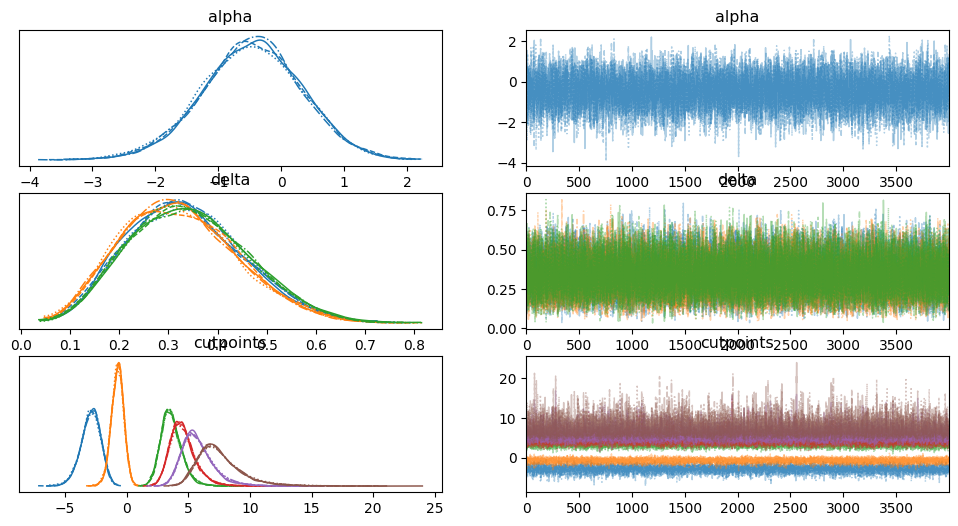

In [14]:
az.plot_trace(boxh2_trace, var_names=["alpha", "delta","cutpoints"])

In [15]:
az.summary(boxh2_trace, var_names="alpha")

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha -0.467  0.798  -2.034    0.988      0.008    0.006   10369.0   10700.0   

       r_hat  
alpha    1.0

In [16]:
with mboxh2:
    pm.sample_posterior_predictive(boxh2_trace, extend_inferencedata=True, random_seed=rng)

Sampling: [y]


Output()

<Axes: xlabel='y'>

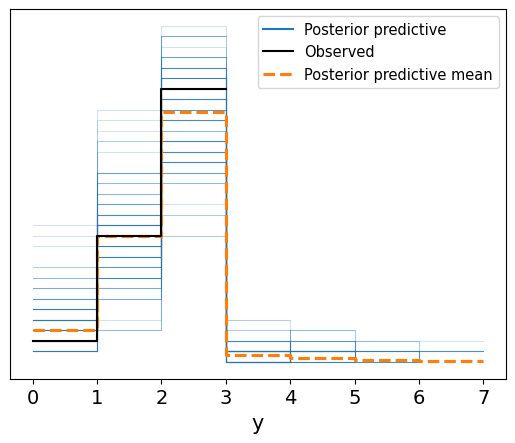

In [17]:
az.plot_ppc(
    boxh2_trace,
    num_pp_samples=100
)

## H3. A player's performance(Score) has an effect on its perception of immersion



In [18]:
scores_st = (scores - scores.mean())/scores.std()
scores_st

array([ 1.53450827, -0.80866364,  0.72651796, -0.7009316 , -1.18572578,
       -0.75479762, -0.32386945,  0.13399173,  1.02278107, -0.99719471,
       -0.56626654,  0.0531927 , -0.37773547,  0.5918529 ,  2.36943159,
       -0.35080246,  0.0531927 , -1.18572578, -0.32386945,  0.64571892,
       -0.27000343, -0.64706558,  0.94198204, -1.10492675, -0.21613741,
       -0.13533838, -0.27000343, -0.99719471, -1.13185976, -0.21613741,
        0.99584806,  1.04971408, -1.05106073,  0.51105387, -0.67399859,
        3.50061803,  0.56491989,  0.94198204, -0.62013257, -0.72786461])

In [19]:
with pm.Model() as mboxh3:
    beta = pm.Normal('beta', 0,5)
    sigma = pm.Exponential("sigma", 1)
    S = pm.Data("CH", scores_st)
    eta = pm.Deterministic("eta", beta*S)
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,2,2), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=imm_codes)

    boxh3_trace = pm.sample_prior_predictive(draws=50, random_seed=rng)
    
    

Sampling: [beta, cutpoints, sigma, y]


In [20]:
with mboxh3:
    boxh3_trace.extend(pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng, nuts_sampler="numpyro"))

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

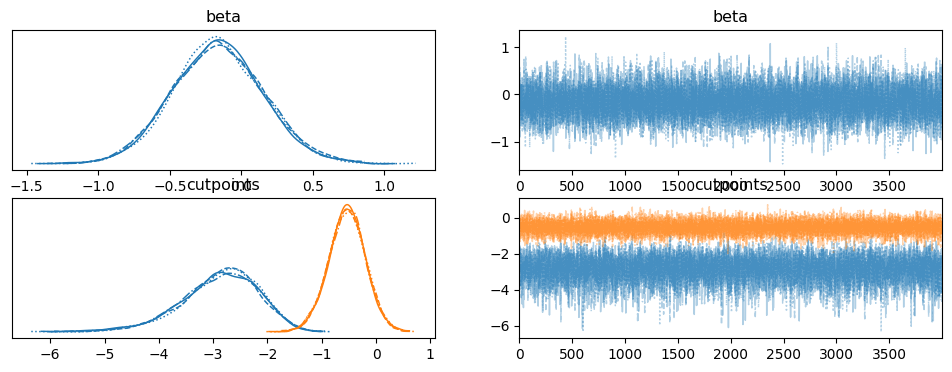

In [21]:
az.plot_trace(boxh3_trace,var_names=["beta","cutpoints"])

In [22]:
az.summary(boxh3_trace,var_names=["beta", "cutpoints"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta         -0.163  0.318  -0.762    0.431      0.003    0.003   10582.0   
cutpoints[0] -2.876  0.714  -4.225   -1.616      0.009    0.007    6786.0   
cutpoints[1] -0.537  0.338  -1.191    0.085      0.002    0.002   18501.0   

              ess_tail  r_hat  
beta            9203.0    1.0  
cutpoints[0]    6128.0    1.0  
cutpoints[1]   11725.0    1.0

## H4. A game's score has an effect on their perception of Mastery

In [23]:
with pm.Model() as mboxh4:
    beta = pm.Normal('beta', 0,5)
    sigma = pm.Exponential("sigma", 1)
    S = pm.Data("CH", scores_st)
    eta = pm.Deterministic("eta", beta * S)
    
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=mas_codes)
    
    
    boxh4_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, target_accept=0.95, random_seed=rng, nuts_sampler="numpyro")
    



  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

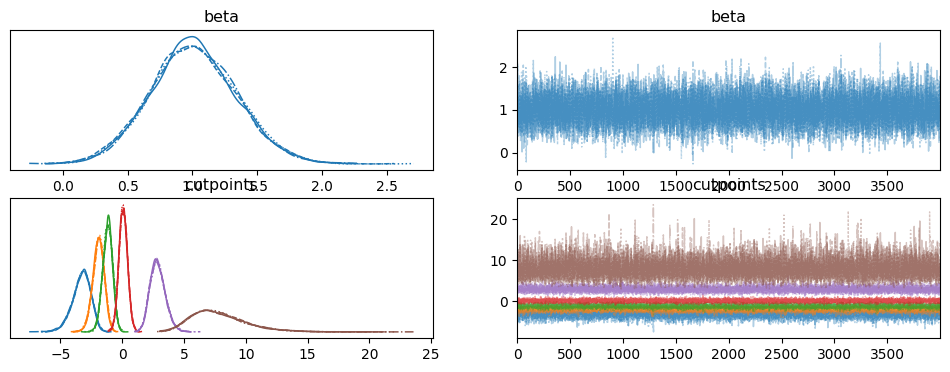

In [24]:
az.plot_trace(boxh4_trace, var_names=["beta","cutpoints"])

In [25]:
az.summary(boxh4_trace, var_names=["beta", "cutpoints"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta          1.010  0.332   0.386    1.637      0.003    0.002   13224.0   
cutpoints[0] -3.301  0.735  -4.710   -2.004      0.008    0.006    9293.0   
cutpoints[1] -1.926  0.464  -2.819   -1.086      0.004    0.003   13361.0   
cutpoints[2] -1.184  0.393  -1.924   -0.462      0.003    0.002   14262.0   
cutpoints[3]  0.079  0.344  -0.567    0.723      0.003    0.003   17034.0   
cutpoints[4]  2.875  0.615   1.750    4.026      0.005    0.004   14646.0   
cutpoints[5]  7.825  2.227   4.054   11.957      0.019    0.013   13779.0   

              ess_tail  r_hat  
beta           11146.0    1.0  
cutpoints[0]    9308.0    1.0  
cutpoints[1]   12767.0    1.0  
cutpoints[2]   13628.0    1.0  
cutpoints[3]   12137.0    1.0  
cutpoints[4]   13072.0    1.0  
cutpoints[5]   11470.0    1.0

## H5 a player's perception of Challenge has an effect on its Mastery

In [26]:
with pm.Model(coords={"challenge_responses": ch_levels}) as m_boxh5:
    CH = pm.Data("challenge", ch_codes)
    alpha = pm.Normal("alpha", 0,1)
    delta = pm.Dirichlet("delta", np.ones(len(ch_levels)-1)*7)
    pad = pm.math.concatenate([[0.0], delta])
    cum_delta = pm.Deterministic("cum_delta", pad.cumsum(), dims="challenge_responses")
    sigma = pm.Exponential("sigma", 1)
    
    
    eta = pm.Deterministic("eta", alpha*cum_delta[CH])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=mas_codes)


    
    
    boxh5_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, target_accept=0.97, random_seed=rng, nuts_sampler="numpyro")

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,5]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

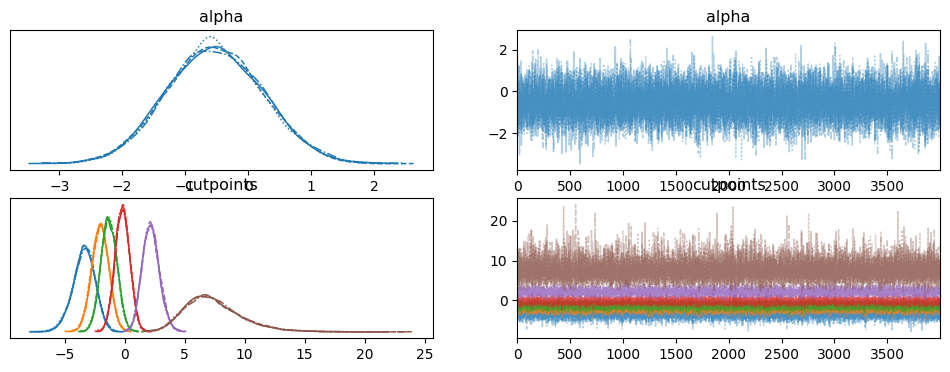

In [27]:
az.plot_trace(boxh5_trace, var_names=["alpha", "cutpoints"])

In [28]:
az.summary(boxh5_trace, var_names=["alpha", "cutpoints"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha        -0.525  0.766  -1.950    0.911      0.006    0.005   14596.0   
cutpoints[0] -3.402  0.927  -5.152   -1.687      0.009    0.006   11522.0   
cutpoints[1] -2.029  0.714  -3.352   -0.687      0.006    0.004   13113.0   
cutpoints[2] -1.314  0.662  -2.517   -0.042      0.006    0.004   13784.0   
cutpoints[3] -0.181  0.609  -1.283    1.002      0.005    0.004   15185.0   
cutpoints[4]  2.191  0.712   0.873    3.532      0.005    0.004   18324.0   
cutpoints[5]  7.427  2.408   3.321   11.953      0.017    0.012   17573.0   

              ess_tail  r_hat  
alpha          11729.0    1.0  
cutpoints[0]   10371.0    1.0  
cutpoints[1]   11361.0    1.0  
cutpoints[2]   11737.0    1.0  
cutpoints[3]   12093.0    1.0  
cutpoints[4]   12921.0    1.0  
cutpoints[5]   10535.0    1.0

# Turmoil

In [67]:
pxi_df_turm = pxi_df[pxi_df["game_name"] == "Turmoil"].drop(columns="game_name")
final_frames = logs_df[logs_df["game_name"]=="Turmoil-v5"].groupby(["participant_id", "trial"])["frame"].idxmax()
grouped_turm_df = logs_df.iloc[list(final_frames.values)]

turm_score = grouped_turm_df[["participant_id", "trial", "ram_9", "ram_10", "ram_57"]]
turm_final = pd.merge(pxi_df_turm, turm_score, left_on=("participant_id", "trial"), right_on=("participant_id", "trial"))


In [68]:
def bcd16_to_decimal(hi_byte: int, lo_byte: int) -> int:
    """
    Convert a 16-bit BCD score (two bytes) to a regular integer.
    
    Parameters:
        hi_byte (int): High BCD byte (tens and thousands).
        lo_byte (int): Low BCD byte (ones and hundreds).
    
    Returns:
        int: The decoded decimal score.
    """
    # Extract nibbles from high byte
    hi_tens = (hi_byte >> 4) & 0x0F
    hi_ones = hi_byte & 0x0F
    
    # Extract nibbles from low byte
    lo_tens = (lo_byte >> 4) & 0x0F
    lo_ones = lo_byte & 0x0F
    
    # Compute decimal value
    return hi_tens * 1000 + hi_ones * 100 + lo_tens * 10 + lo_ones

turm_final["score"] = turm_final.apply(lambda x: bcd16_to_decimal(x['ram_10'], x['ram_9']), 
                        axis=1)
turm_final["deaths"] = 4 - turm_final["ram_57"]

In [69]:
def score_death_ratio(score, deaths):
    if deaths == 0:
        return score
    return score/deaths

turm_final["score_death_ratio"] = turm_final.apply(lambda x: score_death_ratio(x['score'], x['deaths']), 
                        axis=1)

In [71]:
pxi_id_to_number = {
    "strongly disagree": 0,
    "disagree": 1,
    "slightly disagree":2,
    "neutral": 3,
    "slightly agree": 4,
    "agree": 5,
    "strongly agree": 6
}

diff_id,   diff_cats = pd.factorize(turm_final["mode"], sort=True)
ch_codes, ch_levels   = pd.factorize(turm_final["pxi_CH"].str.lower().replace(pxi_id_to_number), sort=True)
mas_codes, mas_levels   = pd.factorize(turm_final["pxi_MAS"].str.lower().replace(pxi_id_to_number), sort=True)
imm_codes, imm_levels   = pd.factorize(turm_final["pxi_IMM"].str.lower().replace(pxi_id_to_number), sort=True)
scores                = turm_final["score_death_ratio"].values

/tmp/ipykernel_74662/2230333994.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ch_codes, ch_levels   = pd.factorize(turm_final["pxi_CH"].str.lower().replace(pxi_id_to_number), sort=True)
/tmp/ipykernel_74662/2230333994.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mas_codes, mas_levels   = pd.factorize(turm_final["pxi_MAS"].str.lower().replace(pxi_id_to_number), sort=True)
/tmp/ipykernel_74662/2230333994.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To r

In [72]:
mas_levels

Index([0, 1, 3, 4, 5, 6], dtype='int64')

## H1: A game's difficulty configuration has an effect on a player's perception of Immersion

In [73]:
imm_levels

Index([4, 5, 6], dtype='int64')

In [74]:
with pm.Model(coords={"difficulties": diff_cats}) as mturmh1:
    D = pm.Data("difficulty", diff_id)
    alpha = pm.Normal("alpha", 0,0.5)
    delta = pm.Dirichlet("delta", np.ones(len(diff_cats)-1)*7)
    pad = pm.math.concatenate([[0.0], delta])
    cum_delta = pm.Deterministic("cum_delta", pad.cumsum(), dims="difficulties")
    sigma = pm.Exponential("sigma", 1)
    
    eta = pm.Deterministic("eta", alpha*cum_delta[D])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,2,2), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=imm_codes)
    
    
    turmh1_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, target_accept=0.97,random_seed=rng, nuts_sampler="numpyro")
    

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,2]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

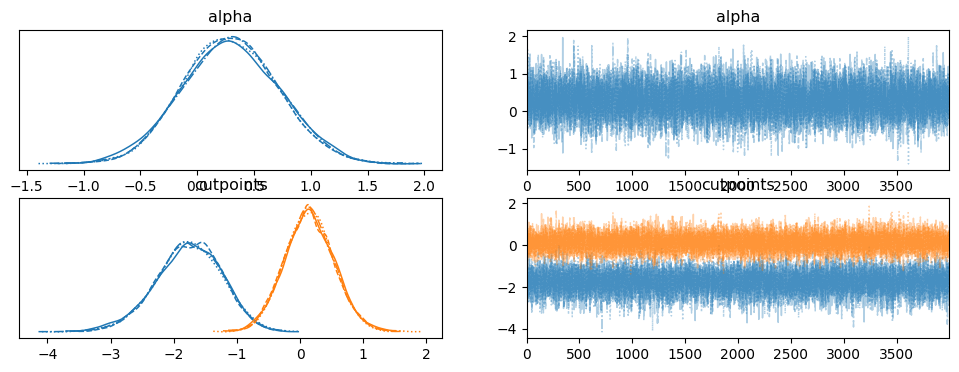

In [75]:
az.plot_trace(turmh1_trace, var_names=["alpha", "cutpoints"])

In [76]:
alpha_summary = az.summary(turmh1_trace, var_names="alpha")
alpha_summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.294  0.425  -0.498     1.09      0.004    0.003   12302.0   11474.0   

       r_hat  
alpha    1.0

## H2: A game's difficulty configuration has an effect on their perception of mastery

In [81]:
with pm.Model(coords={"difficulties": diff_cats}) as mturmh2:
    D = pm.Data("difficulty", diff_id)

    alpha = pm.Normal("alpha", 0,5)
    delta = pm.Dirichlet("delta", np.ones(len(diff_cats)-1)*5)
    pad = pm.math.concatenate([[0.0], delta])
    cum_delta = pm.Deterministic("cum_delta", pad.cumsum(), dims="difficulties")
    
    sigma = pm.Exponential("sigma", 1)
    
    eta = pm.Deterministic("eta", alpha*cum_delta[D])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=mas_codes)
    turmh2_trace = pm.sample_prior_predictive(draws=50, random_seed=rng)
    # boxh2_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng, nuts_sampler="numpyro")
    

Sampling: [alpha, cutpoints, delta, sigma, y]


<Axes: xlabel='y'>

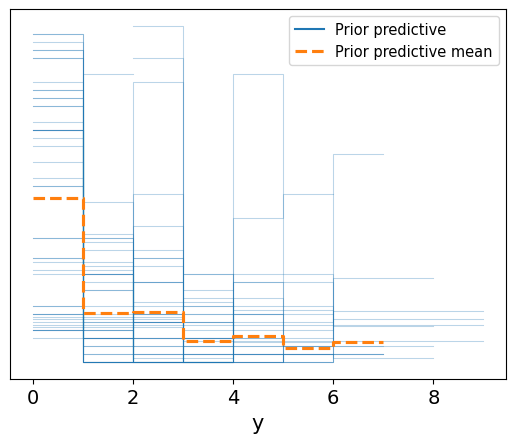

In [82]:
az.plot_ppc(
    turmh2_trace,
    data_pairs={"S": "S"},
    kind="kde",
    alpha=0.3,
    group="prior"
)

In [83]:
with mturmh2:
    turmh2_trace.extend(pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, target_accept=0.95, random_seed=rng, nuts_sampler="numpyro"))

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,2]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

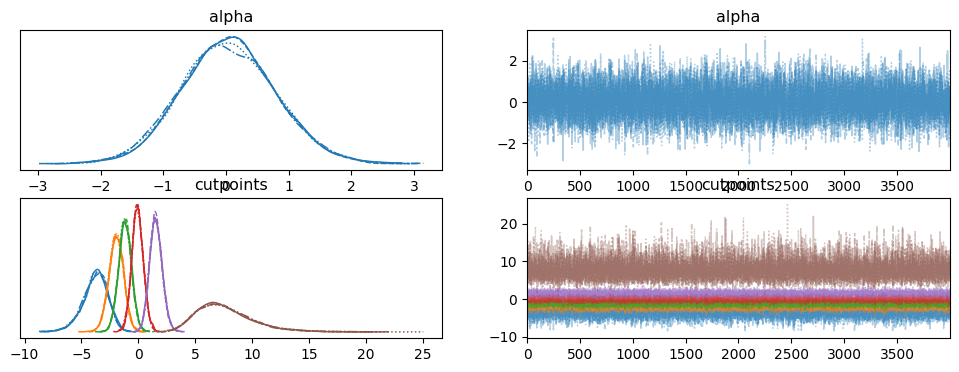

In [84]:
az.plot_trace(turmh2_trace,var_names=["alpha", "cutpoints"])

In [85]:
az.summary(turmh2_trace,var_names=["alpha"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.04  0.755  -1.371    1.463      0.006    0.006   14561.0   11114.0   

       r_hat  
alpha    1.0

## H3. A player's performance(Score) has an effect on its perception of immersion




In [86]:
scores_st = (scores - scores.mean())/scores.std()

In [87]:
with pm.Model() as mturmh3:
    beta = pm.Normal('beta', 0,2)
    sigma = pm.Exponential("sigma", 1)
    S = pm.Data("CH", scores_st)
    eta = pm.Deterministic("eta", beta * S)
    
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,2,2), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=imm_codes)

    turmh3_trace = pm.sample_prior_predictive(draws=50, random_seed=rng)
    
    

Sampling: [beta, cutpoints, sigma, y]


In [88]:
with mturmh3:
    turmh3_trace.extend(pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng, nuts_sampler="numpyro"))

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

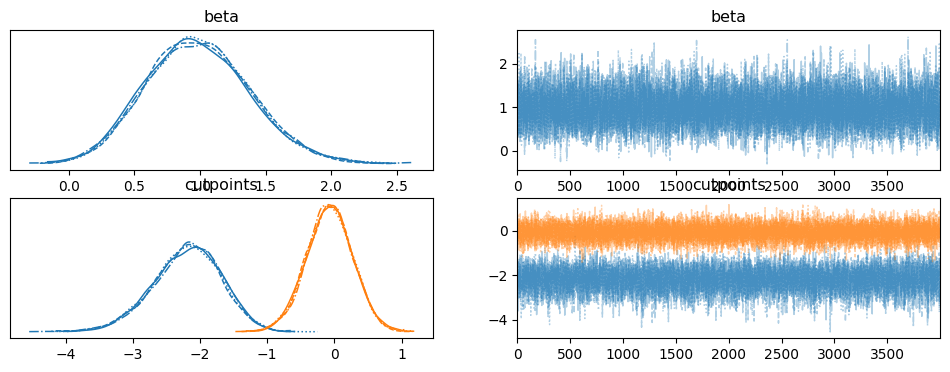

In [89]:
az.plot_trace(turmh3_trace,var_names=["beta","cutpoints"])

In [90]:
az.summary(turmh3_trace,var_names=["beta", "cutpoints"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta          0.987  0.395   0.268    1.739      0.004    0.003   11529.0   
cutpoints[0] -2.195  0.507  -3.187   -1.303      0.006    0.004    7591.0   
cutpoints[1] -0.073  0.344  -0.726    0.570      0.002    0.002   19465.0   

              ess_tail  r_hat  
beta           10464.0    1.0  
cutpoints[0]    8742.0    1.0  
cutpoints[1]   13526.0    1.0

In [91]:
with mturmh3:
    pm.sample_posterior_predictive(turmh3_trace, extend_inferencedata=True, random_seed=rng)

Sampling: [y]


Output()

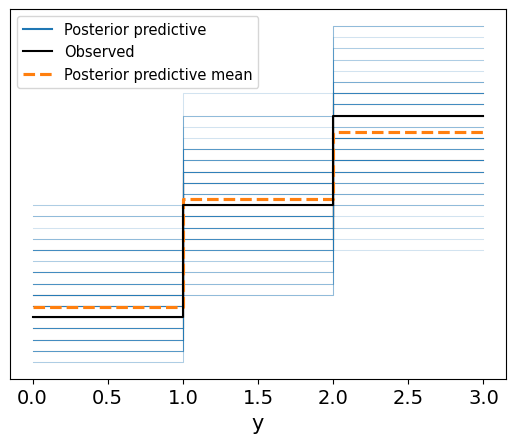

In [92]:
az.plot_ppc(turmh3_trace, num_pp_samples=100);

## H4. A game's score has an effect on their perception of Mastery

In [93]:
with pm.Model() as mturmh4:
    beta = pm.Normal('beta', 0,5)
    sigma = pm.Exponential("sigma", 1)
    S = pm.Data("CH", scores_st)
    eta = pm.Deterministic("eta", beta * S)
    
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=mas_codes)
    
    
    turmh4_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, target_accept=0.97, random_seed=rng, nuts_sampler="numpyro")
    



  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

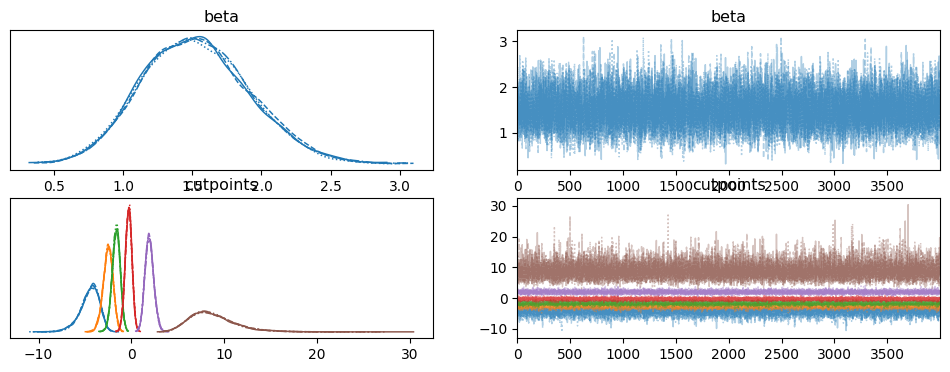

In [94]:
az.plot_trace(turmh4_trace, var_names=["beta", "cutpoints"])

In [95]:
az.summary(turmh4_trace, var_names=["beta", "cutpoints"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta          1.526  0.389   0.827    2.274      0.003    0.002   13763.0   
cutpoints[0] -4.518  1.045  -6.473   -2.696      0.012    0.009    8051.0   
cutpoints[1] -2.531  0.525  -3.519   -1.546      0.004    0.003   14316.0   
cutpoints[2] -1.648  0.429  -2.468   -0.861      0.004    0.003   13910.0   
cutpoints[3] -0.310  0.357  -0.993    0.350      0.003    0.002   15498.0   
cutpoints[4]  1.933  0.468   1.072    2.824      0.004    0.003   16898.0   
cutpoints[5]  8.743  2.512   4.514   13.348      0.023    0.017   12862.0   

              ess_tail  r_hat  
beta           10436.0    1.0  
cutpoints[0]    7463.0    1.0  
cutpoints[1]   13253.0    1.0  
cutpoints[2]   12963.0    1.0  
cutpoints[3]   13006.0    1.0  
cutpoints[4]   13296.0    1.0  
cutpoints[5]   10639.0    1.0

## H5 a player's perception of Challenge has an effect on its perception of mastery

In [110]:
with pm.Model(coords={"challenge_responses": ch_levels}) as m_turmh5:
    CH = pm.Data("challenge", ch_codes)
    alpha = pm.Normal("alpha", 0,1)
    delta = pm.Dirichlet("delta", np.ones(len(ch_levels)-1)*7)
    pad = pm.math.concatenate([[0.0], delta])
    cum_delta = pm.Deterministic("cum_delta", pad.cumsum(), dims="challenge_responses")
    sigma = pm.Exponential("sigma", 1)
    
    
    eta = pm.Deterministic("eta", alpha*cum_delta[CH])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=mas_codes)


    
    
    turmh5_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True},target_accept=0.975, random_seed=rng, nuts_sampler="numpyro")

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,4]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

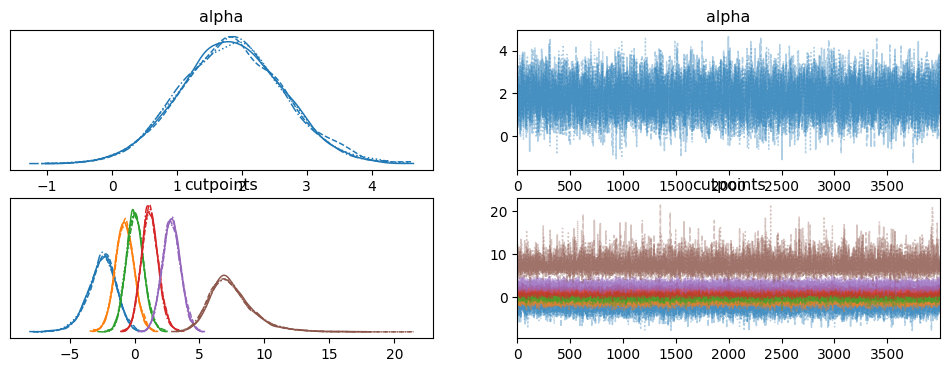

In [111]:
az.plot_trace(turmh5_trace, var_names=["alpha", "cutpoints"])

In [112]:
az.summary(turmh5_trace, var_names="alpha")

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  1.846  0.798   0.352    3.353      0.009    0.007    8125.0    7696.0   

       r_hat  
alpha    1.0

## H6 A player's Score, conditioned on its Perception of Challenge, has an effect on its perception of mastery

In [113]:
with pm.Model(coords={"challenge_responses": ch_levels}) as m_turmh6:
    CH = pm.Data("challenge", ch_codes)
    S = pm.Data("score", scores_st)
    
    alpha = pm.Normal("alpha", 0,1)
    beta = pm.Normal("beta", 0,1)
    delta = pm.Dirichlet("delta", np.ones(len(ch_levels)-1)*7)
    pad = pm.math.concatenate([[0.0], delta])
    cum_delta = pm.Deterministic("cum_delta", pad.cumsum(), dims="challenge_responses")

    sigma = pm.Exponential("sigma", 1)
    
    eta = pm.Deterministic("eta", alpha*S + beta*cum_delta[CH])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=mas_codes)
    
    
    turmh6_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, target_accept=0.95, random_seed=rng, nuts_sampler="numpyro")

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,4]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

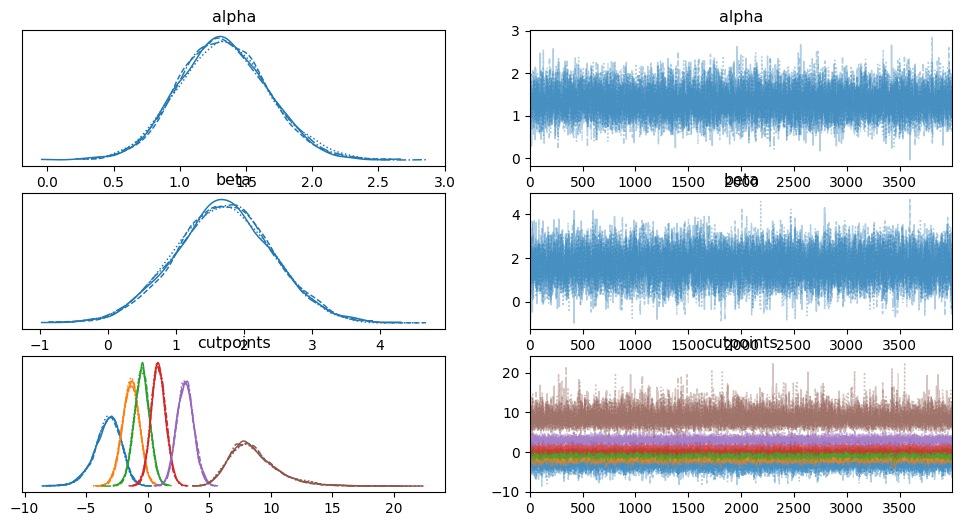

In [114]:
az.plot_trace(turmh6_trace, var_names=["alpha", "beta", "cutpoints"])

In [115]:
az.summary(turmh6_trace, var_names=["alpha", "beta"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  1.329  0.337   0.703    1.966      0.003    0.002   14686.0   11920.0   
beta   1.701  0.716   0.302    3.004      0.006    0.005   13032.0   11019.0   

       r_hat  
alpha    1.0  
beta     1.0

<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_loo (deviance)', ylabel='ranked models'>

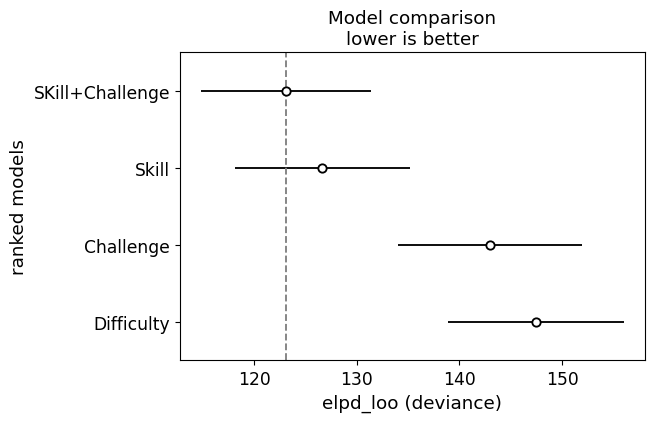

In [116]:
compare_dict = {
    "Difficulty":turmh2_trace,
    "Skill":turmh4_trace,
    "Challenge":turmh5_trace,
    "SKill+Challenge":turmh6_trace,
}

compare_df = az.compare(compare_dict,scale="deviance")

az.plot_compare(compare_df)

## H7 a player's perception of Challenge has an effect on its perception of Immersion

In [119]:
with pm.Model(coords={"challenge_responses": ch_levels}) as m_turmh7:
    CH = pm.Data("challenge", ch_codes)
    alpha = pm.Normal("alpha", 0,0.5)
    delta = pm.Dirichlet("delta", np.ones(len(ch_levels)-1)*7)
    pad = pm.math.concatenate([[0.0], delta])
    cum_delta = pm.Deterministic("cum_delta", pad.cumsum(), dims="challenge_responses")
    sigma = pm.Exponential("sigma", 1)
    
    
    eta = pm.Deterministic("eta", alpha*cum_delta[CH])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,2,2), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=imm_codes)


    
    
    turmh7_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True},target_accept=0.975, random_seed=rng, nuts_sampler="numpyro")

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,4]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

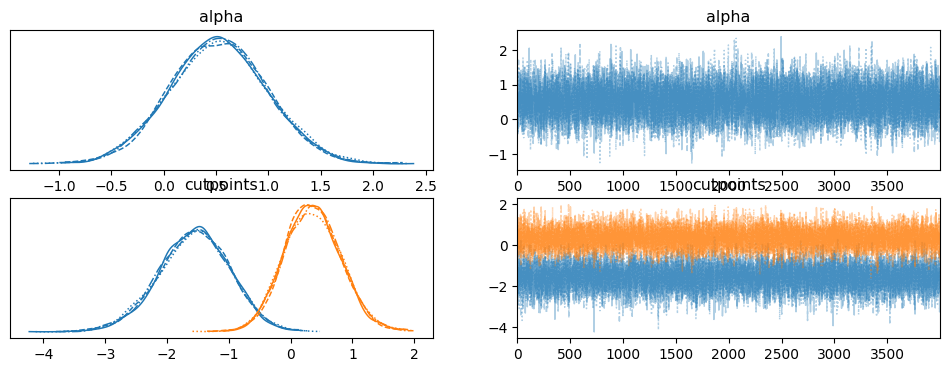

In [120]:
az.plot_trace(turmh7_trace, var_names=["alpha", "cutpoints"])

In [121]:
az.summary(turmh7_trace, var_names="alpha")

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.527  0.468  -0.364    1.393      0.005    0.004   10396.0   10228.0   

       r_hat  
alpha    1.0

# Word Zapper

In [209]:
pxi_df_word = pxi_df[pxi_df["game_name"] == "WordZapper"].drop(columns="game_name")
final_frames = logs_df[logs_df["game_name"]=="WordZapper-v5"].groupby(["participant_id", "trial"])["frame"].idxmax()
grouped_word_df = logs_df.iloc[list(final_frames.values)]

word_score = grouped_turm_df[["participant_id", "trial", "ram_98"]]
word_final = pd.merge(pxi_df_word, word_score, left_on=("participant_id", "trial"), right_on=("participant_id", "trial"))


In [210]:
diff_id,   diff_cats = pd.factorize(word_final["difficulty"].replace(diff_order), sort=True)
ch_codes, ch_levels   = pd.factorize(word_final["pxi_CH"].str.lower().replace(pxi_id_to_number), sort=True)
mas_codes, mas_levels   = pd.factorize(word_final["pxi_MAS"].str.lower().replace(pxi_id_to_number), sort=True)
imm_codes, imm_levels   = pd.factorize(word_final["pxi_IMM"].str.lower().replace(pxi_id_to_number), sort=True)
scores                = word_final["ram_98"].values

/tmp/ipykernel_64458/3899615534.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ch_codes, ch_levels   = pd.factorize(word_final["pxi_CH"].str.lower().replace(pxi_id_to_number), sort=True)
/tmp/ipykernel_64458/3899615534.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mas_codes, mas_levels   = pd.factorize(word_final["pxi_MAS"].str.lower().replace(pxi_id_to_number), sort=True)
/tmp/ipykernel_64458/3899615534.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To reta

In [213]:
mas_levels

Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')

## H1: A game's difficulty configuration or current trial have an effect on on a player's perception of challenge

In [71]:
y_ch.unique()

array([0, 4, 2, 1, 5, 6, 3])

In [72]:
with pm.Model(coords={"difficulties": unique_diff, "trials": unique_trial}) as m_wordh1:
    current_difficulty = pm.Data("difficulty", diff_id)
    current_trial = pm.Data("trial", trial_id)
    
    alpha = pm.Normal("alpha", 0, 0.5, dims="difficulties")
    beta = pm.Normal("beta", 0, 0.5, dims="trials")
    sigma = pm.Exponential("sigma", 0.25)
    
    eta = pm.Deterministic("eta", alpha[current_difficulty] + beta[current_trial]) # 
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=y_ch.values)
    
    wordh1_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng)
    
    

Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

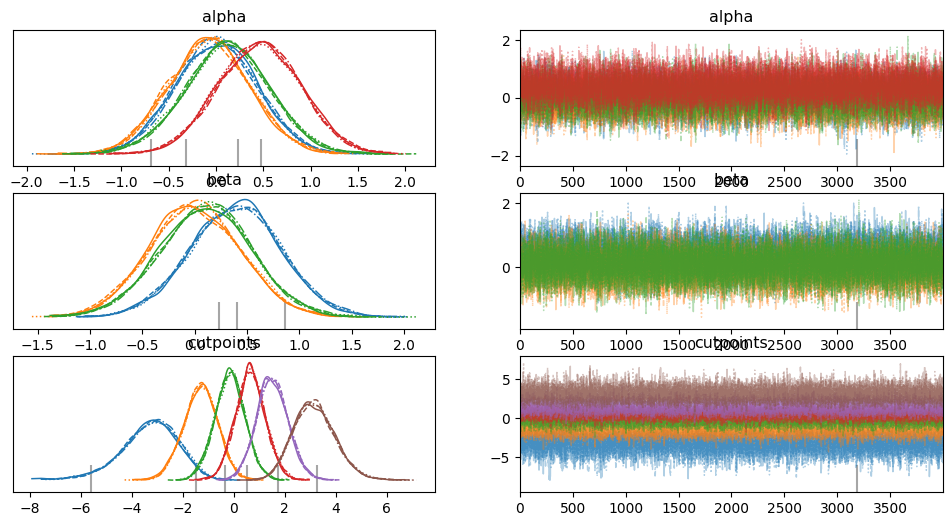

In [ ]:
az.plot_trace(wordh1_trace, var_names=["alpha", "beta", "cutpoints"])

In [ ]:
alpha_summary = az.summary(wordh1_trace, var_names="alpha")
alpha_summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[2.0]  0.004  0.431  -0.793    0.818      0.003    0.004   20375.0   
alpha[1.0] -0.071  0.427  -0.859    0.740      0.003    0.004   19663.0   
alpha[0.0]  0.123  0.449  -0.718    0.975      0.003    0.004   17110.0   
alpha[3.0]  0.457  0.435  -0.362    1.257      0.003    0.003   17425.0   

            ess_tail  r_hat  
alpha[2.0]   11137.0    1.0  
alpha[1.0]   11672.0    1.0  
alpha[0.0]    9709.0    1.0  
alpha[3.0]   10232.0    1.0

In [ ]:
beta_summary = az.summary(wordh1_trace, var_names="beta")
beta_summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[1.0]  0.392  0.433  -0.450    1.182      0.003    0.003   19044.0   
beta[2.0]  0.000  0.433  -0.827    0.797      0.003    0.003   16885.0   
beta[3.0]  0.108  0.438  -0.723    0.928      0.003    0.004   19307.0   

           ess_tail  r_hat  
beta[1.0]   11295.0    1.0  
beta[2.0]   11617.0    1.0  
beta[3.0]   10638.0    1.0

#### interaction model

In [ ]:
with pm.Model(coords={"trials": unique_trial, "difficulties": unique_diff}) as m_wordh2_int:
    current_trial = pm.Data("trial", trial_id)
    current_difficulty = pm.Data("difficulty", diff_id)
    
    beta = pm.Normal("beta", 0, 0.5, dims="trials")
    alpha = pm.Normal("alpha", 0, 0.5, dims="difficulties")
    gamma = pm.Normal("gamma", 0, 0.5, dims=("difficulties", "trials"))
    sigma = pm.Exponential("sigma", 0.25)
    
    eta = pm.Deterministic("eta", alpha[current_difficulty] + beta[current_trial] + gamma[current_difficulty, current_trial])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedProbit("y", eta=eta, cutpoints=cutpoints, observed=y_ch.values)
    
    wordh2_int_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, gamma, sigma, cutpoints]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 21 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

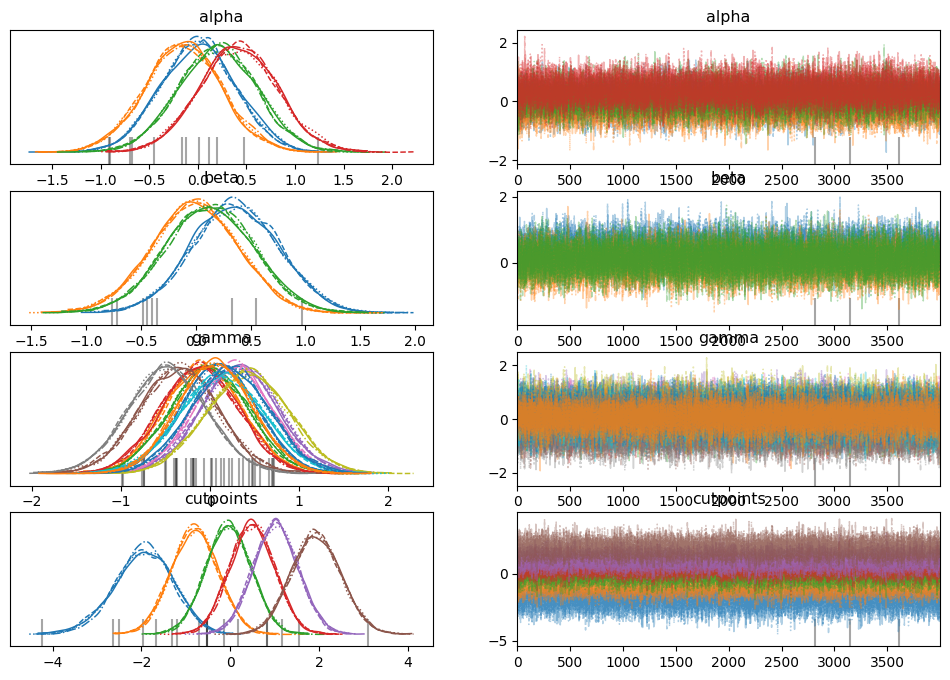

In [ ]:
az.plot_trace(wordh2_int_trace, var_names=["alpha", "beta", "gamma", "cutpoints"])

In [ ]:
alpha_summary_h3 = az.summary(wordh2_int_trace, var_names="alpha")
alpha_summary_h3

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[2.0]  0.003  0.389  -0.719    0.736      0.003    0.003   15874.0   
alpha[1.0] -0.152  0.395  -0.910    0.589      0.003    0.003   16477.0   
alpha[0.0]  0.203  0.405  -0.556    0.967      0.003    0.003   18118.0   
alpha[3.0]  0.417  0.402  -0.349    1.168      0.003    0.002   17548.0   

            ess_tail  r_hat  
alpha[2.0]   12935.0    1.0  
alpha[1.0]   11778.0    1.0  
alpha[0.0]   12445.0    1.0  
alpha[3.0]   12229.0    1.0

In [ ]:
beta_summary_h3 = az.summary(wordh2_int_trace, var_names="beta")
beta_summary_h3

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[1.0]  0.364  0.398  -0.375    1.122      0.003    0.003   16087.0   
beta[2.0] -0.006  0.394  -0.761    0.722      0.003    0.003   15362.0   
beta[3.0]  0.124  0.402  -0.625    0.888      0.003    0.003   14668.0   

           ess_tail  r_hat  
beta[1.0]   12605.0    1.0  
beta[2.0]   12611.0    1.0  
beta[3.0]   11937.0    1.0

In [ ]:
gamma_summary_h3 = az.summary(wordh2_int_trace, var_names="gamma")
gamma_summary_h3

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
gamma[2.0, 1.0]  0.093  0.427  -0.696    0.899      0.003    0.003   20948.0   
gamma[2.0, 2.0] -0.080  0.428  -0.876    0.720      0.003    0.004   21903.0   
gamma[2.0, 3.0] -0.015  0.440  -0.823    0.820      0.003    0.004   23769.0   
gamma[1.0, 1.0] -0.121  0.433  -0.929    0.691      0.003    0.003   22254.0   
gamma[1.0, 2.0]  0.333  0.440  -0.520    1.142      0.003    0.003   21993.0   
gamma[1.0, 3.0] -0.355  0.441  -1.171    0.497      0.003    0.003   19888.0   
gamma[0.0, 1.0]  0.255  0.431  -0.565    1.057      0.003    0.003   23699.0   
gamma[0.0, 2.0] -0.479  0.442  -1.297    0.364      0.003    0.003   22189.0   
gamma[0.0, 3.0]  0.420  0.460  -0.446    1.270      0.003    0.003   21970.0   
gamma[3.0, 1.0]  0.134  0.473  -0.725    1.055      0.003    0.004   23581.0   
gamma[3.0, 2.0]  0.220  0.443  -0.645    1.024      0.003    0.003   21873.0   
gamma[3.0, 3.0]  0.056  0.418  -0.726    0.840      0.003    0.003   20316.0   

                 ess_tail  r_hat  
gamma[2.0, 1.0]   12210.0    1.0  
gamma[2.0, 2.0]   11859.0    1.0  
gamma[2.0, 3.0]   11539.0    1.0  
gamma[1.0, 1.0]   11210.0    1.0  
gamma[1.0, 2.0]   11442.0    1.0  
gamma[1.0, 3.0]   11613.0    1.0  
gamma[0.0, 1.0]   12533.0    1.0  
gamma[0.0, 2.0]   12049.0    1.0  
gamma[0.0, 3.0]   12055.0    1.0  
gamma[3.0, 1.0]   11318.0    1.0  
gamma[3.0, 2.0]   11455.0    1.0  
gamma[3.0, 3.0]   11096.0    1.0